In [1]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 19.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=0ddcfafa46ed2939ad0eb2ab9fc18b54f6eb2d2a7117579158b932096470e56e
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

spark = SparkSession.builder.appName("Titanic-Dataset").config('spark.driver.memory','15g').getOrCreate()

df = spark.read.option("header", True).csv('train.csv')

df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [4]:
from pyspark.sql.functions import when, count, col
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

columns_to_drop = ['Ticket', 'Cabin']
df = df.drop(*columns_to_drop)

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [5]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = df.select(
    _mean(col('Age')).alias('mean'),
).collect()

mean = df_stats[0]['mean']
print(mean)

29.69911764705882


In [6]:
df = df.fillna({'Age' : mean})

df.show()
df.printSchema()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|   Fare|Embarked|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|               22|    1|    0|   7.25|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|               38|    1|    0|71.2833|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|               26|    0|    0|  7.925|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|               35|    1|    0|   53.1|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|               35|    0|    0|   8.05|       S|
|          6|       0|     3|    Moran, Mr. James|  male|29.69911764705882|    0|    0| 8.4583|       Q|
|          7|       0|     1|McCarthy, Mr. Tim...|  mal

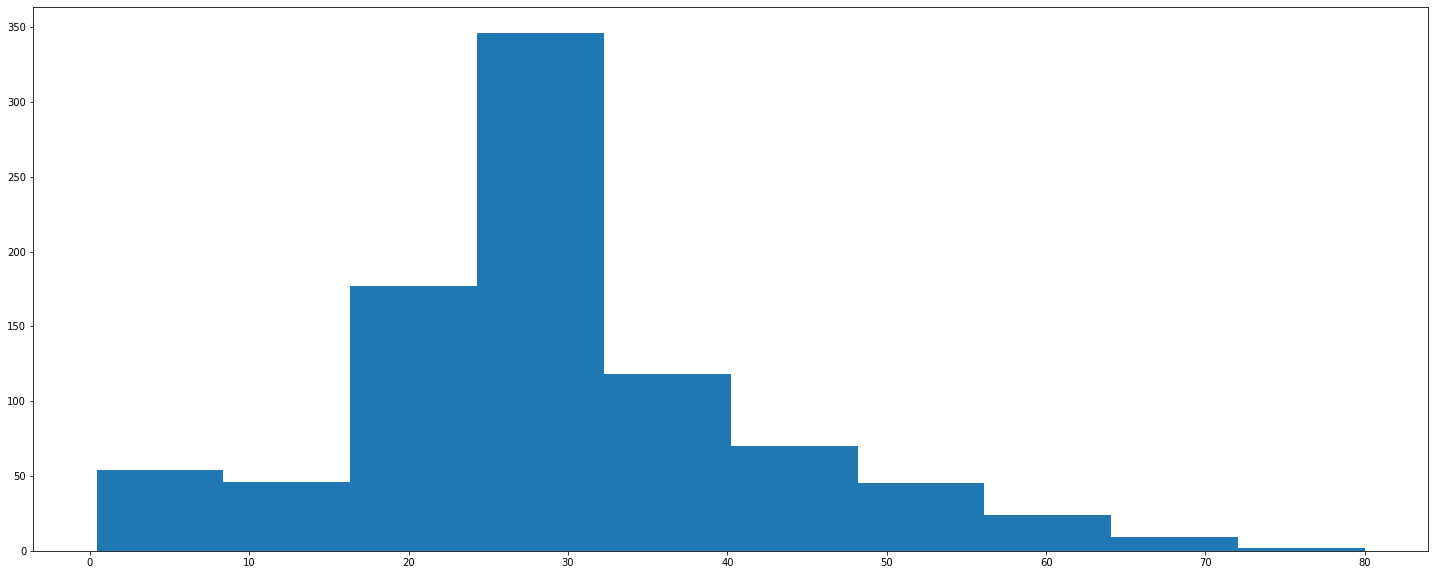

In [7]:
df = df.fillna({'Embarked': '0'})
df_pd = df.toPandas()
age_list = list(df_pd['Age'])

age_list = [float (i) for i in age_list]
age_list.sort()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 10)
plt.hist(age_list)
plt.show()

In [8]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

sex_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
pclass_indexer = StringIndexer(inputCol="Pclass", outputCol="PclassIndex")
age_indexer = StringIndexer(inputCol="Age", outputCol="AgeIndex")
sibsp_indexer = StringIndexer(inputCol="SibSp", outputCol="SibspIndex")
parch_indexer = StringIndexer(inputCol="Parch", outputCol="ParchIndex")
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
onehotencoder_sex_vector = OneHotEncoder(inputCol="SexIndex", outputCol="SexHot")
onehotencoder_pclass_vector = OneHotEncoder(inputCol="PclassIndex", outputCol="PclassHot")
onehotencoder_age_vector = OneHotEncoder(inputCol="AgeIndex", outputCol="AgeHot")
onehotencoder_sibsp_vector = OneHotEncoder(inputCol="SibspIndex", outputCol="SibspHot")
onehotencoder_parch_vector = OneHotEncoder(inputCol="ParchIndex", outputCol="ParchHot")
onehotencoder_embarked_vector = OneHotEncoder(inputCol="EmbarkedIndex", outputCol="EmbarkedHot")

pipeline = Pipeline(stages=[sex_indexer,
                            pclass_indexer,
                            age_indexer,
                            sibsp_indexer,
                            parch_indexer,
                            embarked_indexer,
                            onehotencoder_sex_vector,
                            onehotencoder_pclass_vector,
                            onehotencoder_age_vector,
                            onehotencoder_sibsp_vector,
                            onehotencoder_parch_vector,
                            onehotencoder_embarked_vector
                    ])

df_transformed = pipeline.fit(df).transform(df)
df_transformed.show()

from pyspark.sql.types import IntegerType

df_transformed = df_transformed.withColumn("Survived", df_transformed["Survived"].cast(IntegerType()))


+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|   Fare|Embarked|SexIndex|PclassIndex|AgeIndex|SibspIndex|ParchIndex|EmbarkedIndex|       SexHot|    PclassHot|         AgeHot|     SibspHot|     ParchHot|  EmbarkedHot|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|               22|    1|    0|   7.25|       S|     0.0|        0.0|     2.0|       1.0|       0.0|          0.0|(1,[0],[1.0])|(2,[0],[1.0])| (88,[2],[1.0])|(6,[1],[1.0])|(

In [9]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=['SexHot',
                                'PclassHot',
                                'AgeHot',
                                'SibspHot',
                                'ParchHot',
                                'EmbarkedHot'],
                    outputCol='vector')

pipeline = Pipeline(stages=[va])

df_transformed = pipeline.fit(df_transformed).transform(df_transformed)
df_transformed.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+--------------------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|   Fare|Embarked|SexIndex|PclassIndex|AgeIndex|SibspIndex|ParchIndex|EmbarkedIndex|       SexHot|    PclassHot|         AgeHot|     SibspHot|     ParchHot|  EmbarkedHot|              vector|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+-------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+--------------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|               22|    1|    0|   7.25|       S|     0.0|        0.0|     2.0|       1.0|       0.0|          

In [10]:
train, test = df_transformed.randomSplit([0.8, 0.2], seed=None)

train = train.withColumn('testOrtrain', lit('train'))
test = test.withColumn('testOrtrain', lit('test'))

train.show()
test.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+--------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+--------------------+-----------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|    Fare|Embarked|SexIndex|PclassIndex|AgeIndex|SibspIndex|ParchIndex|EmbarkedIndex|       SexHot|    PclassHot|         AgeHot|     SibspHot|     ParchHot|  EmbarkedHot|              vector|testOrtrain|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+--------+--------+--------+-----------+--------+----------+----------+-------------+-------------+-------------+---------------+-------------+-------------+-------------+--------------------+-----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|               22|    1|    0|    7.25|       S|     0.0|        0.0| 

In [37]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

lr = (LogisticRegression().
      setLabelCol('Survived').
      setFeaturesCol('vector').
      setRegParam(0.0).
      setMaxIter(100).
      setElasticNetParam(0.)
      )

lrmodel = lr.fit(train)

lrDf = lrmodel.transform(test)
lrDf.groupBy('prediction', 'Survived').count().show()

evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol='Survived')
print(evaluator.evaluate(lrDf)*100 , '%')

+----------+--------+-----+
|prediction|Survived|count|
+----------+--------+-----+
|       1.0|       0|   13|
|       0.0|       0|   89|
|       0.0|       1|   21|
|       1.0|       1|   41|
+----------+--------+-----+

76.69196710942441 %


In [38]:
from sklearn.metrics import precision_score
survived_list = list(lrDf.select('Survived').toPandas()['Survived'])
prediction_list = list(lrDf.select('prediction').toPandas()['prediction'])

print("precision ", precision_score(survived_list, prediction_list, average='micro'))

precision  0.7926829268292683


In [35]:
print("coefficients:", lrmodel.coefficients)

print("intercept: ", lrmodel.intercept)
print()

print("avg of 'Age' coefficients")
age_list = [float (i) for i in lrmodel.coefficients[3:91]]
sum = 0
for a in age_list:
  if a<0:
    sum+=(a*-1)
  else:
    sum+=a
print(sum/88)

print("avg of 'Sibsp' coefficients")
age_list = [float (i) for i in lrmodel.coefficients[91:97]]
sum = 0
for a in age_list:
  if a<0:
    sum+=(a*-1)
  else:
    sum+=a
print(sum/6)

print("avg of 'Parch' coefficients")
age_list = [float (i) for i in lrmodel.coefficients[97:103]]
sum = 0
for a in age_list:
  if a<0:
    sum+=(a*-1)
  else:
    sum+=a
print(sum/6)

coefficients: [-3.0453521046227303,-0.7727621859876808,1.4160107334340686,-384.1564249533121,-383.656630887193,-383.7922258037415,-383.99393614591685,-383.730653014296,-384.13733591772643,-383.69183503802486,-384.6110791056672,-383.89130909074345,-383.2914574518148,-383.0917234409824,-383.3665741636376,-382.3248907561535,-381.3688186253296,-382.7592997674926,-382.98809583051786,-383.92969343874927,-383.35852397050206,-383.9052036902627,-383.20535615935216,-383.04327316369694,-385.0023664356245,-383.8503919601325,-384.49612090144956,-383.16379608984414,-384.1080215188952,-384.32237682913086,-385.8162202418499,-380.3204703241811,-384.4282752722277,-384.05980974381714,-4427.433564742148,-382.79002826452427,-384.8504025198143,-382.63229436662704,-379.35385855472504,-383.88210460568047,-384.1341299539762,-379.55259349856044,-3870.359400791165,-384.88345857003384,-384.89285889073864,-383.58987993273144,-382.49643610724155,-384.19657861257446,-384.94758735078653,-382.1509978264837,3112.020188